In [49]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/bregression/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)

<module 'postprocessing_utils' from '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/bregression/python/postprocessing_utils.pyc'>

In [50]:
ntuples = 'heppy_05_10_2017'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n

ttbar= [s for s in files if "20trees_safe" in s] #large statistics
#ttbar= [s for s in files if "ttbar_RegressionPerJet.root" in s] # only limited statistics


utils.IO.add_target(ntuples,ttbar,1)
utils.IO.add_features(ntuples,ttbar,1)

for i in range(len(utils.IO.targetName)):        
    print "using target file n."+str(i)+": "+utils.IO.targetName[i]
for i in range(len(utils.IO.featuresName)):        
    print "using features file n."+str(i)+": "+utils.IO.featuresName[i]

env: data=/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017
using target file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017/ttbar_RegressionPerJet_heppyregression_20trees_safe.root
using features file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017/ttbar_RegressionPerJet_heppyregression_20trees_safe.root


In [78]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
#noexpand:fabs(CosThetaStar_CS)
branch_names = 'Jet_pt,noexpand:Jet_mcPt/Jet_pt,Jet_eta,Jet_corr,Jet_mcPt,Jet_mcFlavour,dR,rho,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR,Jet_neHEF,Jet_neEmEF,Jet_chMult,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL'.split(",")

features = 'Jet_pt,Jet_eta,Jet_corr,rho,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR,Jet_neHEF,Jet_neEmEF,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL'.split(",")
#target = 'Jet_mcPt'.split(",")
target = 'Jet_mcPt/Jet_pt'.split(",")
#cuts='Jet_mcPt > 20 and dR < 0.35 and (Jet_mcFlavour==5 or Jet_mcFlavour==-5) and Jet_pt > 15'
cuts='(Jet_mcPt > 20) & (Jet_mcFlavour==5 | Jet_mcFlavour==-5) & (Jet_pt > 15) & (Jet_eta<2.4 & Jet_eta>-2.4) & (dR < 0.4)'



branch_names = [c.strip() for c in branch_names]
features = [c.strip() for c in features]
target = [c.strip() for c in target]

#print branch_names

import pandas as pd
import root_pandas as rpd


X_features = preprocessing.set_features("tree",branch_names,features,cuts)
X_target = preprocessing.set_target("tree",branch_names,target,cuts)
X_features,X_target=preprocessing.randomize_ft(X_features,X_target)

#print max(X_features[:,1])

#print X_target
#print pd.DataFrame(utils.IO.features_df[0],columns=['Jet_eta'])

X_train_target = preprocessing.get_training_sample(pd.DataFrame(X_target))
X_train_features = preprocessing.get_training_sample(pd.DataFrame(X_features))

X_test_target = preprocessing.get_test_sample(pd.DataFrame(X_target))
X_test_features = preprocessing.get_test_sample(pd.DataFrame(X_features))

#X_target_data =  pd.DataFrame(utils.IO.data_df[0],columns=['Jet_mcPt'])
#X_data_target = utils.IO.data_df[0][['Jet_mcPt']]
#new_jet_mcPt = jet_mcPt.query('Jet_mcPt > 30')

from sklearn.externals import joblib
import xgboost as xgb
import matplotlib.pyplot as plt

all_data_frame = (rpd.read_root(utils.IO.featuresName[0],"tree", columns = branch_names)).query(cuts)
for j in range(len(branch_names)):
    if j == 0:
        X_all = all_data_frame[[branch_names[j].replace('noexpand:','')]]
    else:
        X_all = np.concatenate([X_all,all_data_frame[[branch_names[j].replace('noexpand:','')]]],axis=1)

log_names='Jet_pt,Jet_mcPt,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR'.split(",")
#plotting.plot_input_variables_reg(X_features,features,log_names)
#plotting.plot_input_variables_reg(X_all,branch_names,log_names)
#plt.show()


IndexError: list index out of range

In [52]:
########final optimization with all fixed#######

from sklearn.externals import joblib
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.grid_search import GridSearchCV


#clf = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
    #   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=9,
    #   min_child_weight=1e-05, missing=None, n_estimators=1500, nthread=20,
    #   objective='reg:linear', reg_alpha=0, reg_lambda=0.1,
    #   scale_pos_weight=1, seed=0, silent=True, subsample=1)

clf = xgb.XGBRegressor(objective='reg:linear')
#param_grid = {'n_estimators': [100,500]}
#grid_scores = optimization.optimize_parameters_gridCV_ref(xgb_model,X_train_features,X_train_target,X_test_features,X_test_target,param_grid)

#clf = GridSearchCV(xgb_model, {'max_depth': [4,5,6]}, verbose=1,n_jobs==-1)
clf.fit(X_train_features,X_train_target)
#print clf.best_score_
#print clf.best_params_
#joblib.dump(clf, os.path.expanduser('~/HHbbgg_ETH_devel/bregression/output_files/regression_heppy_mcPt_cuts.pkl'), compress=9)
predictions = clf.predict(X_test_features)
#print predictions, predictions.shape
actuals = X_test_target
true = (actuals.as_matrix()).ravel()
recoPt = (X_test_features[0].as_matrix()).ravel()
##print true, true.shape
#print true[0]/predictions[0]
ratio = true/predictions
ratio=1/ratio
reco_ratio=true/recoPt
reco_ratio=1./reco_ratio
#print ratio.shape
#print ratio


#print(mean_squared_error(actuals, predictions))
#print type(actuals), type(predictions)



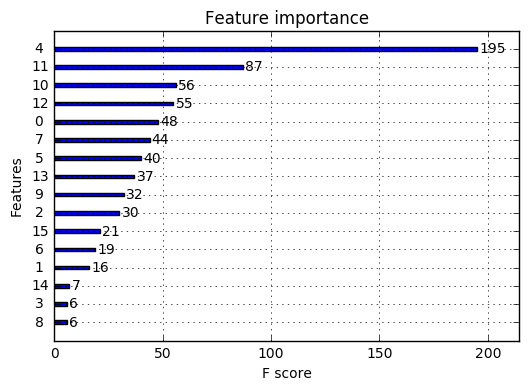

Nominal : mean, RMS : 1.08785812201 0.220830823361
Regresesd : mean, RMS :  0.993160583029 0.192813242991


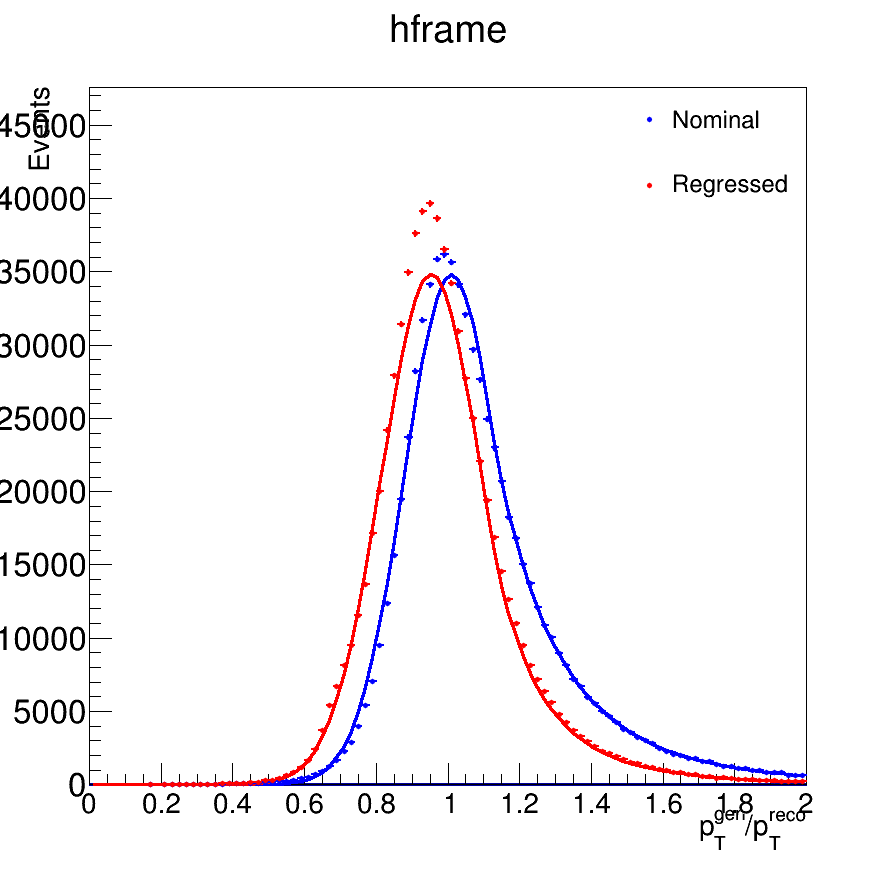

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(roohist_nom): fit range of variable x_hrel_diff_nom expanded to nearest bin boundaries: [0,2] --> [0,2]
[#1] INFO:Minization -- RooMinuit::optimizeConst: activating const optimization
 **********
 **   13 **MIGRAD        2000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=-144927 FROM MIGRAD    STATUS=INITIATE       24 CALLS          25 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  alpha_nom   -7.78020e-01   3.89010e-01   1.50103e-01   1.44789e+02
   2  exp_nom      6.01490e+00   2.50745e+00   1.19440e-01  -1.96629e+01
   3  mean_nom     1.01030e+00   1.00000e-01   2.01403e-01   5.24016e+02
   4  sigma_nom    1.32100e-01   2.90

Info in <TCanvas::Print>: png file /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/bregression/plots/pt_rel_fit_None.png has been created


In [82]:
import matplotlib.pyplot as plt
import training_utils as utils
import ROOT
from ROOT import gROOT
import plotting_utils as plotting
#import training_utils as utils
reload(utils)
reload(plotting)

regressed_pt = predictions*recoPt
true_pt = true*recoPt

xgb.plot_importance(clf)
plt.show()
plt.savefig(utils.IO.plotFolder+"importance1.pdf")

style=False
#plotting.plot_rel_pt_diff(predictions,true,recoPt,style,100,)
plotting.plot_rel_pt_diff(regressed_pt,true_pt,recoPt,style,100,)



#n, bins, patches = plt.hist(ratio, 40, range=(0,4),normed=0, facecolor='g', alpha=0.75,label='regressed')
#n2, bins2, patches2 = plt.hist(reco_ratio, 40, range=(0,4),normed=0, facecolor='r', alpha=0.75,label='reco')

#plt.grid(True)
#plt.ylabel('Events')
#plt.xlabel('$p_{T}/p_T true$')
#plt.show()



# gROOT.Reset()
# c1 = TCanvas( 'c1', '', 200, 10, 700, 500 )
# c1.SetGridx()
# c1.SetGridy()




# hratio = TH1D("ratio", "ratio", 400, 0, 4)
# for i in xrange(len(ratio)): 
#     hratio.Fill(ratio[i])
# hreco_ratio = TH1D("reco_ratio", "reco_ratio", 400, 0, 4)
# for i in xrange(len(reco_ratio)): 
#     hreco_ratio.Fill(reco_ratio[i]) 
# hratio.Draw()
# hreco_ratio.Draw("same")
# c1.Update()
# c1.SaveAs("test_mcPT.png")
# print hratio.GetMean(), hreco_ratio.GetMean()
# print hratio.GetRMS(), hreco_ratio.GetRMS()

# c2 = ROOT.TCanvas( 'c2', '', 200, 10, 700, 500 )
# c2.SetGridx()
# c2.SetGridy()
# htrue = ROOT.TH1D("htrue", "htrue", 50, 0, 400)
# htrue.Sumw2(ROOT.kTRUE)
# for i in xrange(len(true)): 
#     htrue.Fill(true[i])

# hpred = ROOT.TH1D("hpred", "hpred", 50, 0, 400)
# #hpred = ROOT.TH1D("hpred", "hpred", 50, 0, 2)
# hpred.Sumw2(ROOT.kTRUE)
# for i in xrange(len(predictions)):  
#     hpred.Fill(predictions[i]*recoPt[i]) 
#    #print predictions[i]*recoPt[i]
    
# #hpred.Divide(htrue)
# hpred.GetXaxis().SetTitle("Jet_pt")
# hpred.GetYaxis().SetTitle("Prediction Pt/True")
# hpred.Draw("PE")
# c2.Draw()
# c2.SaveAs(utils.IO.plotFolder+'pred_true_mcPt.png')

#plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg_resWeight_optimized_noDR_minDRGJet_dijetMass")
#plt.show()
#fpr_gJets_2ndtest_2,tpr_gJets_2ndtest_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString="xgbr_gJets_resWeighting_optimized_noDR_minDRGJet_withDR_dijetMass",weights=w_total_test)
#plt.show()
#fpr_dipho_2ndtest_2,tpr_dipho_2ndtest_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString="xgbr_diphotons_resWeighting_optimized_noDR_minDRGJet_withDR_dijetMass",weights=w_total_test)
#plt.show()

In [58]:
branch_names = 'noexpand:fabs(Jet_pt),Jet_eta,Jet_corr,Jet_mcPt,Jet_mcFlavour,dR,rho,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR,Jet_neHEF,Jet_neEmEF,Jet_chMult,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL'.split(",")
treeName="tree"
tmp_data_frame = (rpd.read_root("/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017/ttbar_RegressionPerJet_heppyregression_20trees_safe.root",treeName, columns = branch_names))

In [10]:
tmp_data_frame.describe()

,Jet_eta,Jet_corr,Jet_mcPt,Jet_mcFlavour,dR,rho,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR,Jet_neHEF,Jet_neEmEF,Jet_chMult,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL,fabs(Jet_pt)
count,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06,5.819422e+06
mean,6.200861e-05,1.022648e+00,6.280092e+01,5.658020e+00,7.321274e+02,1.589347e+01,6.119155e+01,1.223609e+01,1.436068e-01,2.720730e+00,9.376143e-03,1.691169e-01,2.715997e-01,1.261169e-44,5.235471e+00,3.552907e-01,2.283100e-01,7.132045e-01,4.597322e+00,6.007726e+01
std,1.602279e+00,9.109097e-02,4.958754e+01,9.818018e+00,4.453084e+02,6.620511e+00,5.036552e+01,1.361024e+01,5.036864e-01,9.188586e+00,2.647505e-02,2.506667e-01,1.840485e-01,0.000000e+00,1.283349e+01,8.274453e-01,7.063038e-01,1.547273e+00,1.355647e+01,5.013912e+01
min,-4.699923e+00,3.598607e-01,-3.407892e+02,-5.000000e+00,6.914139e-06,0.000000e+00,1.501569e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01
25%,-1.086038e+00,9.963294e-01,3.017023e+01,-2.000000e+00,1.846201e-01,1.111519e+01,2.770967e+01,4.269531e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.476381e-02,1.291193e-01,8.407791e-45,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.715041e+01
50%,5.927983e-04,1.039321e+00,4.772323e+01,3.000000e+00,9.990000e+02,1.495675e+01,4.660909e+01,8.375000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.883567e-02,2.428050e-01,1.261169e-44,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.589050e+01
75%,1.087548e+00,1.102173e+00,7.819130e+01,2.100000e+01,9.990000e+02,1.966853e+01,7.727431e+01,1.574219e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.925509e-01,3.822618e-01,1.821688e-44,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.635835e+01
max,4.699936e+00,1.643377e+00,2.248924e+03,2.100000e+01,9.990000e+02,6.847440e+01,2.278700e+03,9.555000e+02,6.588474e+01,8.564111e+02,1.600000e-01,1.000000e+00,1.000000e+00,1.135052e-43,4.353914e+02,6.499464e+00,1.870210e+01,1.500000e+01,4.370366e+02,2.276175e+03


In [20]:
utils.IO.features_df[0].describe()

,Jet_eta,Jet_corr,Jet_mcPt,Jet_mcFlavour,dR,rho,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR,Jet_neHEF,Jet_neEmEF,Jet_chMult,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL,fabs(Jet_pt)
count,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06,5.816501e+06
mean,1.004024e-04,1.022691e+00,6.284227e+01,5.656525e+00,7.319937e+02,1.589202e+01,6.121064e+01,1.224092e+01,1.436740e-01,2.722045e+00,9.380182e-03,1.690259e-01,2.716181e-01,1.261169e-44,5.238045e+00,3.554618e-01,2.284161e-01,7.135446e-01,4.599524e+00,6.009707e+01
std,1.601953e+00,9.103233e-02,4.953683e+01,9.813163e+00,4.453637e+02,6.619763e+00,5.036973e+01,1.361163e+01,5.037900e-01,9.190495e+00,2.647895e-02,2.505953e-01,1.840481e-01,0.000000e+00,1.283567e+01,8.275293e-01,7.064326e-01,1.547210e+00,1.355905e+01,5.014376e+01
min,-4.699923e+00,3.598607e-01,2.000000e+01,-5.000000e+00,6.914139e-06,0.000000e+00,1.501569e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01
25%,-1.085778e+00,9.963696e-01,3.019012e+01,-2.000000e+00,1.840835e-01,1.111424e+01,2.772899e+01,4.273438e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.475349e-02,1.291401e-01,8.407791e-45,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.717046e+01
50%,6.264882e-04,1.039335e+00,4.774581e+01,3.000000e+00,9.990000e+02,1.495533e+01,4.663122e+01,8.382812e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.880008e-02,2.428269e-01,1.261169e-44,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.591403e+01
75%,1.087343e+00,1.102181e+00,7.821200e+01,2.100000e+01,9.990000e+02,1.966657e+01,7.729594e+01,1.575000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.924128e-01,3.822800e-01,1.821688e-44,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.638000e+01
max,4.699936e+00,1.643377e+00,2.248924e+03,2.100000e+01,9.990000e+02,6.847440e+01,2.278700e+03,9.555000e+02,6.588474e+01,8.564111e+02,1.600000e-01,1.000000e+00,1.000000e+00,1.135052e-43,4.353914e+02,6.499464e+00,1.870210e+01,1.500000e+01,4.370366e+02,2.276175e+03


Jet_mcPT/Jet_pt
yes
Jet_mcPT_Jet_pt
